## Necessary Libraries

In [1]:
from PIL import Image
import numpy as np
import numpy.linalg as LA
from numpy.linalg import norm
from scipy.spatial import distance_matrix
#import cupy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
%matplotlib inline

## Defining function to update TSDF

In [2]:
from numba import jit, njit, prange, cuda

def update_TSDF(Wt, Dt, K, TSDF, tau, idces, dc_idces):
    xt = np.matmul(Wt,np.hstack([dc_idces.T, np.ones([dc_idces.shape[1], 1])])[...,None])[:,:,0].T
    uc = K.dot(xt)
    xt = xt[2,:]
    uc = (uc/uc[-1:,:]).astype(int)
    mask = ~np.any(np.vstack([np.isnan(uc.sum(0)), uc[0,:]<0, uc[1,:]<0, uc[0,:]>=Dt.shape[0], uc[1,:]>=Dt.shape[1]]), axis=0)
    psdf = Dt[uc[0,:][mask],uc[1,:][mask]]-xt[mask]
    psdf[psdf>tau] = tau
    psdf_mask = psdf>-tau
    mask[mask] = np.logical_and(mask[mask], psdf_mask)
    masked_idces = idces[:,mask]
    TSDF[masked_idces[0,:], masked_idces[1,:], masked_idces[2,:]] = psdf[psdf_mask]

# #@njit(nopython=True, parallel=True, nogil=True )
@cuda.jit
def update_TSDF2(Wt, Dt, K, TSDF, tau, xmin, xmax, ymin, ymax, zmin, zmax):
    for i in prange(TSDF.shape[0]):
        for j in prange(TSDF.shape[1]):
            for k in prange(TSDF.shape[2]):
                xc0 = i/TSDF.shape[0]*(xmax-xmin)+xmin
                xc1 = j/TSDF.shape[1]*(ymax-ymin)+ymin
                xc2 = k/TSDF.shape[2]*(zmax-zmin)+zmin
                W = Wt[i,j,k,...]
                xt0 = xc0*W[0,0]+xc1*W[0,1]+xc2*W[0,2]+W[0,3]
                xt1 = xc0*W[1,0]+xc1*W[1,1]+xc2*W[1,2]+W[1,3]
                xt2 = xc0*W[2,0]+xc1*W[2,1]+xc2*W[2,2]+W[2,3]
                uc0 = xt0*K[0,0]+xt1*K[0,1]+xt2*K[0,2]
                uc1 = xt0*K[1,0]+xt1*K[1,1]+xt2*K[1,2]
                uc2 = xt0*K[2,0]+xt1*K[2,1]+xt2*K[2,2]
                if uc2==0:
                    continue
                uc0 /= uc2
                uc1 /= uc2
                if uc0<0 or uc1<0 or uc0>=Dt.shape[0] or uc1>=Dt.shape[1] or Dt[int(uc0), int(uc1)]==0:
                    continue
                psdf = Dt[int(uc0), int(uc1)] - xt2
                if psdf<=-tau:
                    continue
                TSDF[i,j,k] = min(tau, psdf)

## Update TSDF

In [3]:
from time import time
VERSION = 1
start = time()
x_range = (-1,1)
y_range = (-1,1)
z_range = (0,3)
N = 128
tau = (z_range[1]-z_range[0])/N*3
TSDF = np.ones((N,N,N))*tau
if VERSION==1:
    idces = np.stack(np.meshgrid(np.arange(TSDF.shape[0]), np.arange(TSDF.shape[1]), np.arange(TSDF.shape[2])), 3).reshape([-1,3]).T
    dc_idces = idces/np.array(TSDF.shape)[:,None]*\
        np.array([[x_range[1]-x_range[0]],[y_range[1]-y_range[0]],[z_range[1]-z_range[0]]])+\
        np.array([[x_range[0]],[y_range[0]],[z_range[0]]])
K = np.array([[570.342, 0, 320], [0, 570.342, 240], [0, 0, 1]])
Kinv = np.linalg.inv(K)
Dt = np.array(Image.open('./photos/frame-000000.depth.png'))/1000
if VERSION==1:
    Wt = np.repeat(np.eye(3,4)[None,...], dc_idces.shape[1], 0)
elif VERSION==2:
    Wt2 = np.repeat(np.repeat(np.repeat(np.eye(3,4)[None, None, None,...], TSDF.shape[2], 2), TSDF.shape[1], 1), TSDF.shape[0], 0)
ckp1 = time()
if VERSION==1:
    update_TSDF(Wt, Dt, K, TSDF, tau, idces, dc_idces)
elif VERSION==2:
    update_TSDF2(Wt2, Dt, K, TSDF, tau, *x_range, *y_range, *z_range)
ckp2 = time()
# Use marching cubes to obtain the surface mesh
verts, faces, normals, values = measure.marching_cubes_lewiner(TSDF, 0)
end = time()
print("Version: {}, Data Prep: {:.3f}s, Calculating TSDF: {:.3f}s, Marching Cube: {:.3f}s, Total: {:.3f}s".format(VERSION, ckp1-start, ckp2-ckp1, end-ckp2, end-start))

verts[:,0] = verts[:,0]/N*(x_range[1]-x_range[0])+x_range[0]
verts[:,1] = verts[:,1]/N*(y_range[1]-y_range[0])+y_range[0]
verts[:,2] = verts[:,2]/N*(z_range[1]-z_range[0])+z_range[0]
verts = verts.astype(np.float64)
normals = normals.astype(np.float64)
verts_new = verts.copy()
normals_new = normals.copy()
verts_warp = verts_new.copy()
normals_warp = normals_new.copy()

/Users/yujieli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/yujieli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Version: 1, Data Prep: 0.497s, Calculating TSDF: 0.326s, Marching Cube: 0.080s, Total: 0.903s


## Visualize the TSDF as image, comparing with real depth map

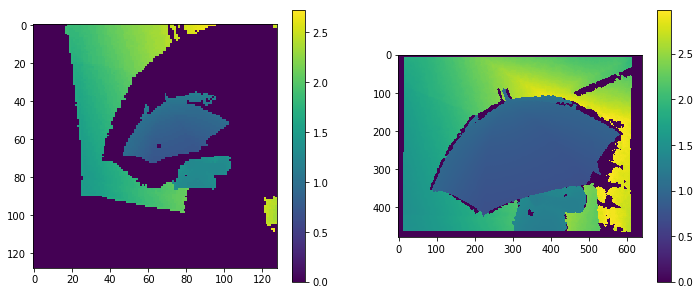

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
test_depth = np.zeros((TSDF.shape[0], TSDF.shape[1]))
for i in range(TSDF.shape[0]):
    for j in range(TSDF.shape[1]):
        candidates = np.where(np.diff(np.sign(TSDF[i,j,:])))
        if len(candidates[0])>0:
            test_depth[i,j] = candidates[0][0]/TSDF.shape[2]*(z_range[1]-z_range[0])+z_range[0]
plt.imshow(test_depth)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Dt)
plt.colorbar()
plt.show()

## Writing to OBJ file

In [6]:
f = open("object.obj", "wt")
f.write("# OBJ file created by some python code\n")
f.write("#\n")
f.write("g Obj{}\n".format(N))
f.write("\n")
for v in verts:
    f.write("v  {:.4f}  {:.4f}  {:.4f}\n".format(v[0], v[1], v[2]))
f.write("\n")
for n in normals:
    f.write("n  {:.4f}  {:.4f}  {:.4f}\n".format(n[0], n[1], n[2]))
f.write("\n")
for face in faces:
    f.write("f  {:.4f}  {:.4f}  {:.4f}\n".format(face[0]+1, face[1]+1, face[2]+1))
f.close()

## Directly Visualize TSDF

In [502]:
import ipyvolume
ipyvolume.volshow(TSDF, True)
hfg

NameError: name 'hfg' is not defined

# Nodes

In [5]:
def getNodes(vertices, radius, n_nodes=np.inf):
    nodes = np.array([], dtype=np.int)
    idces = np.arange(vertices.shape[0])
    while idces.shape[0]>0 and nodes.shape[0]<n_nodes:
        idx = np.random.choice(idces, size=(1,))
        D = distance_matrix(vertices[idx,:], vertices[idces,:])<=radius
        nodes = np.append(nodes, [idx])
        idces = idces[~np.any(D, axis=0)]
    return nodes

In [6]:
def k_nearest(verts, nodes, k):
    result = np.zeros((verts.shape[0], k))
    result_D = np.zeros((verts.shape[0], k))
    max_per_slice = int(np.floor(1e7/nodes.shape[0])) #about 800 MB memory
    n_slices = int(np.ceil(verts.shape[0]/max_per_slice))
    for i in range(n_slices):
        cur_slice_length = min(verts.shape[0]-i*max_per_slice, max_per_slice)
        D = distance_matrix(verts[i*max_per_slice:i*max_per_slice+cur_slice_length], nodes)
        result[i*max_per_slice:i*max_per_slice+cur_slice_length, :k] = np.argsort(D, axis=1)[:, :k]
        result_D[i*max_per_slice:i*max_per_slice+cur_slice_length, :k] = np.sort(D, axis=1)[:, :k]
    return result.astype(np.int), result_D

In [7]:
def add_node(e_node,n_vert,radius):#e_node s existing nodes, n_vert is the new vertices
    i=0;n=np.Inf;n_node=[]
    for i in range(e_node.shape[0]):
        diffnorm=np.linalg.norm(n_vert-e_node[i,:],axis=1)
        del_ind=np.where(diffnorm<radius)[0]
        n_vert=np.delete(n_vert,del_ind,axis=0)
    new_nodes=nodes(n_vert,radius)
    n_nodes=np.vstack((e_node,new_nodes))
    return n_nodes

In [8]:
def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    if x.ndim == 1:
        return np.hstack((x,1))
    else:
        return np.vstack((x,np.ones((1,x.shape[1]))))


def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1] / x[-1]

In [11]:
start_time=time()
nodes_idx=getNodes(verts,0.035)
dg_v=verts[nodes_idx]
print("Number of nodes:", dg_v.shape[0])
print("--- %s seconds ---" % (time() - start_time))

Number of nodes: 1647
--- 0.6417069435119629 seconds ---


In [13]:
start_time=time()
verts_neighbor, verts_neighbor_dist = k_nearest(verts,dg_v,10)
print("--- %s seconds ---" % (time() - start_time))

--- 4.3907411098480225 seconds ---


In [14]:
def calc3DMap_opt(depthmap,K):
    K_inv=LA.inv(K)
    vl_check=np.ones((480,640,3))
    vl_check[:,:,0]=np.tile(np.arange(480),(640,1)).T
    vl_check[:,:,1]=np.tile(np.arange(640),(480,1))
    worldPts=np.transpose(np.matmul(K,np.transpose(vl_check,(1,2,0))),(2,0,1))
    return worldPts*np.reshape(depthmap,(480,640,1))

depthmap = np.array(Image.open('./photos/frame-000000.depth.png')) / 1000.
vl_u = calc3DMap_opt(depthmap, K)

In [15]:
def calc3DMap(depthmap,K):
    K_inv = LA.inv(K)
    mask = np.zeros_like(depthmap, dtype=bool)
    mask[np.nonzero(depthmap)] = True
    m, n = depthmap.shape[:2]
    world_pts = np.zeros((m, n, 3))
    for i in range(m):
        for j in range(n):
            world_pts[i, j] = K_inv @ np.array([i, j, 1.]) * depthmap[i, j]

    return world_pts, mask


depthmap = np.array(Image.open('./photos/frame-000000.depth.png')) / 1000.
vl_u, mask_sensor = calc3DMap(depthmap, K)

In [72]:
nVerts = verts.shape[0]
nNodes = dg_v.shape[0]
nNeighbors = 10
dg_se3 = (np.ones((nNodes, 6)) + np.random.rand(nNodes,6)) / 4.
dg_w = np.ones(nNodes) / 10.

# dg_se3_new = dg_se3.copy()
# dg_v_new = dg_v.copy()

In [73]:
dg_se3

array([[ 0.27801396,  0.41616479,  0.45630368,  0.33510107,  0.34026418,
         0.28379797],
       [ 0.39466555,  0.28248818,  0.432937  ,  0.41851991,  0.39566693,
         0.25390176],
       [ 0.34723233,  0.44697509,  0.41724939,  0.37096637,  0.40677339,
         0.36241496],
       ..., 
       [ 0.28459871,  0.32243853,  0.40295898,  0.4152648 ,  0.27595925,
         0.49957538],
       [ 0.32919912,  0.27094753,  0.26381446,  0.28593977,  0.49180767,
         0.34822148],
       [ 0.34216583,  0.47173929,  0.46669852,  0.30958028,  0.38249911,
         0.48889956]])

In [1000]:
hessian = np.zeros((6*nNodes, 6*nNodes))
start_time=time()
hessian = jacobian.T @ jacobian
print("--- %s seconds ---" % (time() - start_time))

--- 19.405783891677856 seconds ---


In [ ]:
start_time=time()
inv_H = LA.pinv(hessian)
print("--- %s seconds ---" % (time() - start_time))

In [18]:
verts_neighbor.max()

1646

In [21]:
def calcDataJacobian(verts, normals, dg_v, dg_w, dg_se3, vl_u, mask_sensor, verts_neighbor):
    
    nVerts = verts.shape[0]
    nNodes = dg_v.shape[0]
    nNeighbors = verts_neighbor.shape[1]
    
    error_data = np.zeros(nVerts)
    pixels = np.zeros((nVerts, 2), dtype=np.int)
    jacobian = np.zeros((nVerts, 6*nNodes))
    gradient = np.zeros(6*nNodes)
    hessian_blocks = np.zeros((6*nNodes, 6))
    weights = np.zeros((nVerts, nNeighbors))
    start_time=time()
    proj_count = 0
    
    for i in range(nVerts):
    #     if mask[i] == False:
    #         continue

        neighbors = verts_neighbor[i]
        weights[i] = np.exp(-np.sum((dg_v[neighbors] - verts[i])**2,\
                                axis=1) / (2*dg_w[neighbors]**2))
    #     Dual quaternion of each neighboring node
        dq = se32dq(dg_se3[neighbors])
    #     Blending
        DQB = weights[i] @ dq
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
        norm_DQB = norm(DQB[:4])
        DQB = DQB / norm_DQB
    #     Warping, note that normal does not depend on t
        rMat, tvec = dq2SE3(DQB)
        verts_warped = rMat @ verts[i] + tvec
        normals_warped = rMat @ normals[i] # No translation
    #     Pixels data association
        pixels[i] = np.round(fromHomo(K @ verts_warped)).astype(np.int)
        if (pixels[i]<0).any() or pixels[i,0] >= 480 or pixels[i,1] >= 640 \
        or mask_sensor[pixels[i,0],pixels[i,1]] == False:
            continue
        proj_count += 1
    #     Energy term
        error_data[i] = np.dot(normals_warped, (verts_warped - vl_u[pixels[i,0],pixels[i,1]]))
    #     As the names suggest
        dv_ddq = np.hstack((drotated_dq0(verts[i], DQB[:4]), np.zeros((3,4)))) + dt_ddq(DQB)  
        dn_ddq = np.hstack((drotated_dq0(normals[i], DQB[:4]), np.zeros((3,4)))) # No translation
    #     d_Energy / d_DQB
        block1 = error_data[i] * ((verts_warped - vl_u[pixels[i,0],pixels[i,1]]) @ dn_ddq + normals_warped @ dv_ddq)
    #     Jacobian of DQB WRT each dual quaternion
        for j in range(nNeighbors):
    #         d_DQB / d_dq
            block2 = weights[i,j] * (np.identity(8) / norm_DQB - \
            DQB.reshape(-1,1) @ np.hstack([DQB[:4], [0.,0.,0.,0.]]).reshape(1,-1) / norm_DQB)
    #         Transform back to se3 to calculate d_dq / d_se3
            se3 = dg_se3[neighbors[j]]
    #         Previously se3 = dq2se3(dq[j])
    #         d_dq / d_se3
            block3 = np.hstack((ddq_dw(se3[:3], se3[3:]), np.vstack([np.zeros((4, 3)), dqe_dt(se3[:3])])))
    #         Final Jacobian
            jacobian[i, 6*neighbors[j]:6*neighbors[j]+6] = block1 @ block2 @ block3
    #         Gradient
            gradient[6*neighbors[j]:6*neighbors[j]+6] += \
            error_data[i] * jacobian[i, 6*neighbors[j]:6*neighbors[j]+6]
    #         Diagonal Hessian blocks
            hessian_blocks[6*neighbors[j]:6*neighbors[j]+6] += \
            jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(-1,1)\
            @ jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(1,-1)

    cost_mean = (error_data**2).sum() / (2*proj_count)
    print("Mean cost: ", cost_mean)
    print("Points projected on image planes: ", proj_count, '/', nVerts)
    print("--- %s seconds ---" % (time() - start_time))
    
    return error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient

In [41]:
def updateAll(verts, normals, dg_se3, vl_u, mask_sensor, weights, verts_neighbor,\
              hessian_blocks, gradient, steplength):
    
    dg_se3_new = dg_se3.copy()
    start_time=time()
    proj_count = 0
#     print(steplength)
    for i in range(nNodes):
#         dg_se3_new[i] += LA.pinv(hessian_blocks[6*i:6*i+6]) @ gradient[6*i:6*i+6]
        dg_se3_new[i] = dg_se3_new[i] + steplength * gradient[6*i:6*i+6]
    
    error_data = np.zeros(nVerts)
    for i in range(nVerts):
    #     if mask[i] == False:
    #         continue

        neighbors = verts_neighbor[i]
    #     Dual quaternion of each neighboring node
        dq = se32dq(dg_se3_new[neighbors])
    #     Blending
        DQB = weights[i] @ dq
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
        norm_DQB = norm(DQB[:4])
        DQB = DQB / norm_DQB
    #     Warping, note that normal does not depend on t
        rMat, tvec = dq2SE3(DQB)
        verts_warped = rMat @ verts[i] + tvec
        normals_warped = rMat @ normals[i] # No translation
    #     Pixel data association
        pixel = np.round(fromHomo(K @ verts_warped)).astype(np.int)
        if (pixel<0).any() or pixel[0] >= 480 or pixel[1] >= 640 \
        or mask_sensor[pixel[0],pixel[1]] == False:
            continue
        proj_count += 1  
    #     Energy term
        error_data[i] = np.dot(normals_warped, (verts_warped - vl_u[pixel[0],pixel[1]]))


    cost_mean = (error_data**2).sum() / (2*proj_count)
    print("Updated mean cost: ", cost_mean) 
    print("Points projected on image planes: ", proj_count, '/', nVerts)
    print("--- %s seconds ---" % (time() - start_time))
    
    return dg_se3_new

In [76]:
max_iter = 8
dg_se3_test = dg_se3.copy()
step_length = 1e-2
for n_iter in range(max_iter):
    
    error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient = \
    calcDataJacobian(verts, normals, dg_v, dg_w, dg_se3_test, vl_u, mask_sensor, verts_neighbor)
    
    dg_se3_test = updateAll(verts, normals, dg_se3_test, vl_u, mask_sensor, weights, verts_neighbor,\
              hessian_blocks, gradient, step_length)

Mean cost:  0.275717099106
Points projected on image planes:  1756 / 19343
--- 10.58361005783081 seconds ---
Updated mean cost:  0.283741809579
Points projected on image planes:  1638 / 19343
--- 7.893257141113281 seconds ---
Mean cost:  0.283741809579
Points projected on image planes:  1638 / 19343
--- 10.858786821365356 seconds ---
Updated mean cost:  0.296179136714
Points projected on image planes:  1687 / 19343
--- 7.353271007537842 seconds ---
Mean cost:  0.296179136714
Points projected on image planes:  1687 / 19343
--- 10.337979078292847 seconds ---
Updated mean cost:  0.303725118209
Points projected on image planes:  1693 / 19343
--- 7.457036972045898 seconds ---
Mean cost:  0.303725118209
Points projected on image planes:  1693 / 19343
--- 11.218944072723389 seconds ---
Updated mean cost:  0.305537846125
Points projected on image planes:  1694 / 19343
--- 8.024781942367554 seconds ---
Mean cost:  0.305537846125
Points projected on image planes:  1694 / 19343
--- 10.88915395736

In [60]:
dg_se3_test.mean()

0.023631060862743771

In [74]:
dg_se3.mean()

0.37508906032195616

In [ ]:
max_iter = 20
dg_se3_test = dg_se3.copy()
for n_iter in range(max_iter):
    
    error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient = \
    calcDataJacobian(verts, normals, dg_v, dg_w, dg_se3_test, vl_u, mask_sensor, verts_neighbor)
    
    dg_se3_test = updateAll(verts, normals, dg_se3_test, vl_u, mask_sensor, weights, verts_neighbor,\
              hessian_blocks, gradient, 4e-3)

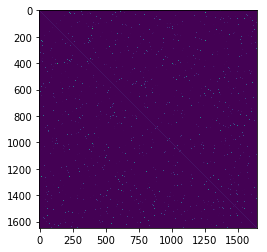

In [77]:
covis_mat = np.zeros((nNodes, nNodes))
for i in range(nVerts):
    for j in range(10):
        covis_mat[verts_neighbor[i], verts_neighbor[i,j]] += 10
    
for i in range(nNodes):
    covis_mat[i,i] = 100

plt.imshow(covis_mat)
plt.show()

In [981]:
covis_mat[verts_neighbor[i]][:,verts_neighbor[i]] += np.ones((10,10))

# Necessary transformations and derivatives

In [23]:
def render(verts, K):
    sensor_plane_pts = K@verts.T
    sensor_plane_pts /= sensor_plane_pts[2,:]
    sensor_plane_pts = sensor_plane_pts[:2,...]
#     It = np.zeros_like(Dt, dtype=np.int)-1
#     It_mask = np.zeros_like(Dt, dtype=np.bool)
    sensor_plane_pts_int = np.round(sensor_plane_pts).astype(np.int)
    mask = np.all([sensor_plane_pts_int[0,:]>=0, 
                   sensor_plane_pts_int[0,:]<It.shape[0], 
                   sensor_plane_pts_int[1,:]>=0, 
                   sensor_plane_pts_int[1,:]<It.shape[1]], axis=0)

#     for i in np.arange(verts.shape[0])[mask]:
#         pix_pos = (sensor_plane_pts_int[0, i], sensor_plane_pts_int[1, i])
#         if It[pix_pos]==-1 or verts[It[pix_pos], 2]>verts[i,2]:
#             It[pix_pos] = i
#             It_mask[pix_pos] = 1
    return sensor_plane_pts_int.T, mask

In [24]:
def cross2mat(w):
    
    return np.array([[0, -w[2], w[1]],
                     [w[2], 0, -w[0]],
                     [-w[1], w[0], 0]])


# Not used
def quatCross(q, p):
#     Quaternion multiply
    return np.hstack([q[0]*p[0]-np.dot(q[1:], p[1:]), q[0]*p[1:] + \
                    p[0]*q[1:] + np.cross(q[1:], p[1:])])

In [25]:
# Verified
def se32dq(se3):
#     Transform se3(nx6) elements to unit dual quaternions(nx8)
    if se3.ndim == 1:
        theta = norm(se3[:3])
        dq = np.zeros(8)
        dq[0] = np.cos(theta/2)
        dq[1:4] = np.sinc(theta/(2*np.pi))*se3[:3]/2
        a, b, c, d = dq[:4]
        t1, t2, t3 = se3[3:]
        dq[4:] = np.array([
            - b*t1 - c*t2 - d*t3,
              a*t1 + d*t2 - c*t3,
            - d*t1 + a*t2 + b*t3,
              c*t1 - b*t2 + a*t3
        ]) / 2
#         dq[4:] = quatCross(np.hstack((0, se3[3:])), dq[:4]) / 2
        
    else:
        num = se3.shape[0]
        dq = np.zeros((num, 8))
        theta = norm(se3[:,:3], axis=1)
        for i in range(num):
            dq[i,:4] = np.hstack((np.cos(theta[i]/2), np.sinc(theta[i]/(2*np.pi))*se3[i,:3]/2))
#             dq[i,4:] = quatCross(np.hstack((0, se3[i,3:])), dq[i,:4]) / 2
            a, b, c, d = dq[i,:4]
            t1, t2, t3 = se3[i,3:]
            dq[i,4:] = np.array([
                - b*t1 - c*t2 - d*t3,
                  a*t1 + d*t2 - c*t3,
                - d*t1 + a*t2 + b*t3,
                  c*t1 - b*t2 + a*t3
            ]) / 2
    return dq


def dq2SE3(dq):
    
#     Transform a unit dual quaternion to R and t
#     dq = dq / norm(dq[:4])
    w, x, y, z = dq[:4]
    mat = np.identity(3)
    #Extract rotational information into the new matrix
    mat[0][0] = w*w + x*x - y*y - z*z
    mat[0][1] = 2*x*y - 2*w*z
    mat[0][2] = 2*x*z + 2*w*y
    mat[1][0] = 2*x*y + 2*w*z
    mat[1][1] = w*w + y*y - x*x - z*z
    mat[1][2] = 2*y*z - 2*w*x
    mat[2][0] = 2*x*z - 2*w*y
    mat[2][1] = 2*y*z + 2*w*x
    mat[2][2] = w*w + z*z - x*x - y*y
    #Extract translation information into t
#     t = 2*quatCross(dq[4:], dq[:4]*np.array([1.,-1.,-1.,-1.]))[1:]
    t = 2*(dq[0]*dq[5:] - dq[4]*dq[1:4] + np.cross(dq[1:4], dq[5:]))

    return mat, t


# This better not be used, since it uses arccos
def dq2se3(dq):
    dq = dq / norm(dq[:4])
    theta = 2 * np.arccos(dq[0])   
    if norm(dq[1:4]) ==0:
        w = np.zeros(3)
        
    else:
        w = dq[1:4] / norm(dq[1:4]) * theta
        
    t = 2*(dq[0]*dq[5:] - dq[4]*dq[1:4] + np.cross(dq[1:4], dq[5:]))
    
    return np.hstack((w, t))

In [26]:
def R2w(R):
    # given a rotation matrix R return the angle-axis representation
    u, s, v = np.linalg.svd(R - np.eye(3))
    v = v[np.argmin(s)]
    vh = np.array([[R[2,1]-R[1,2]], [R[0,2]-R[2,0]], [R[1,0]-R[0,1]]])
    sin = 1/2 * v @ vh
    cos = (np.trace(R) - 1) / 2
    theta = np.arctan2(sin, cos)
    return v * theta

def cross2mat(w):
    
    return np.array([[0, -w[2], w[1]],
                     [w[2], 0, -w[0]],
                     [-w[1], w[0], 0]])


def w2R(w):
    # given the angle-axis representation w return the rotation matrix
    theta = norm(w)
    R = np.eye(3) * np.cos(theta) +\
    np.sinc(theta / np.pi) * np.array([[0, -w[2], w[1]],
                                       [w[2], 0, -w[0]],
                                       [-w[1], w[0], 0]]) +\
    (1 - np.cos(theta)) / theta**2 * w.reshape(-1,1) @ w.reshape(1,-1)
    return R

In [27]:
def dt_ddq(dq):
#     dq = dq / norm(dq[:4])
    q01, q02, q03, q04, qe1, qe2, qe3, qe4 = dq
    
    dt_dq0 = 2 * np.array([
        [qe2, -qe1, qe4, -qe3],
        [qe3, -qe4, -qe1, qe2],
        [qe4, qe3, -qe2, -qe1]
    ])
    dt_dqe = 2 * np.array([
        [-q02, q01, -q04, q03],
        [-q03, q04, q01, -q02],
        [-q04, -q03, q02, q01]
    ])
    return np.hstack((dt_dq0, dt_dqe))

In [28]:
# def render(pts, K):
# #     Pts should be nx3
#     return fromHomo(K @ pts.T).T.astype(np.int)

In [29]:
# Verified
def drotated_dq0(v, q):
#     v is the UNROTATED 3x1 vector, q is the quaternion(q0)
    w, x, y, z = q
    v1, v2, v3 = v
    return 2*np.array([
        [w*v1 - z*v2 + y*v3, x*v1 + y*v2 + z*v3,
         -y*v1 + x*v2 + w*v3, -z*v1 - w*v2 + x*v3],
        [z*v1 + w*v2 - x*v3, y*v1 - x*v2 - w*v3,
         x*v1 + y*v2 + z*v3, w*v1 - z*v2 + y*v3],
        [-y*v1 + x*v2 + w*v3, z*v1 + w*v2 - x*v3,
         -w*v1 + z*v2 - y*v3, x*v1 + y*v2 + z*v3]
    ])

In [30]:
# Verified
# d_q0 / d_t = 0
def dqe_dt(w):
#     Note that this is actually only a function of w
    w1, w2, w3 = w
#     Small angle approximation
    if norm(w) <= 0.6:
        return np.array([
            [-w1/4, -w2/4, -w3/4],
            [1/2, w3/4, -w2/4],
            [-w3/4, 1/2, w1/4],
            [w2/4, -w1/4, 1/2]
        ])
    
    else:
        theta_2 = 0.5 * norm(w)
        sinc_theta_2 = np.sinc(theta_2/np.pi)
        cos_theta_2 = np.cos(theta_2)

        return np.array([
            [-w1*sinc_theta_2/4, -w2*sinc_theta_2/4, -w3*sinc_theta_2/4],
            [cos_theta_2/2, w3*sinc_theta_2/4, -w2*sinc_theta_2/4],
            [-w3*sinc_theta_2/4, cos_theta_2/2, w1*sinc_theta_2/4],
            [w2*sinc_theta_2/4, -w1*sinc_theta_2/4, cos_theta_2/2]
        ])


In [31]:
# Verified
def ddq_dw(w, t):
#     Derivative of dual quaternion WRT w
    w1, w2, w3 = w
    t1, t2, t3 = t
    theta = norm(w)
    dq0_dw = np.zeros((4, 3))
    dqe_dw = np.zeros((4, 3))
#     Small angle approximation
    if theta <= 0.6:
        
        dq0_dw[0] = np.array([-w1/4, -w2/4, -w3/4])
        dq0_dw[1:4] =  0.5 * np.eye(3) - w.reshape(-1,1) @ w.reshape(1,-1) / 24.
        
        dqe_dw[0,0] = 1/48 * (t1*(w1**2 - 12) + w1*(t2*w2 + t3*w3))
        dqe_dw[0,1] = 1/48 * (t2*(w2**2 - 12) + w2*(t1*w1 + t3*w3))
        dqe_dw[0,2] = 1/48 * (t3*(w3**2 - 12) + w3*(t2*w2 + t1*w1))
        dqe_dw[1,0] = -1/48 * w1*(6*t1 - t3*w2 + t2*w3)
        dqe_dw[2,1] = -1/48 * w2*(6*t2 + t3*w1 - t1*w3)
        dqe_dw[3,2] = -1/48 * w3*(6*t3 - t2*w1 + t1*w2)
        dqe_dw[1,1] = 1/48 * (t3*(w2**2 - 12) - w2*(6*t1 + t2*w3))
        dqe_dw[1,2] = 1/48 * (-t2*(w3**2 - 12) - w3*(6*t1 - t3*w2))
        dqe_dw[2,0] = 1/48 * (-t3*(w1**2 - 12) - w1*(6*t2 - t1*w3))
        dqe_dw[2,2] = 1/48 * (t1*(w3**2 - 12) - w3*(6*t2 + t3*w1))
        dqe_dw[3,0] = 1/48 * (t2*(w1**2 - 12) - w1*(6*t3 + t1*w2))
        dqe_dw[3,1] = 1/48 * (-t1*(w2**2 - 12) - w2*(6*t3 - t2*w1))
        
    else:
        
        theta_2 = 0.5 * norm(w)
        sinc_theta_2 = np.sinc(theta_2/np.pi)
        cos_theta_2 = np.cos(theta_2)
        sin_theta_2 = np.sin(theta_2)
        d_sinc = (theta * cos_theta_2 - 2 * sin_theta_2) / theta**3

        dq0_dw =  0.5 * np.array([
            [-w1*sin_theta_2/theta, -w2*sin_theta_2/theta, -w3*sin_theta_2/theta],
            [d_sinc * w1**2 + sinc_theta_2, w1 * w2 * d_sinc, w1 * w3 * d_sinc],
            [w1 * w2 * d_sinc, d_sinc * w2**2 + sinc_theta_2, w2 * w3 * d_sinc],
            [w1 * w3 * d_sinc, w2 * w3 * d_sinc, d_sinc * w3**2 + sinc_theta_2]
        ])

        dqe_dw[0] = - 0.25 * t@w * d_sinc * w - 0.25 *sinc_theta_2 * t
        dqe_dw[1] = w * (t2*w3 - t3*w2) * d_sinc / 4
        dqe_dw[2] = w * (t3*w1 - t1*w3) * d_sinc / 4
        dqe_dw[3] = w * (t1*w2 - t2*w1) * d_sinc / 4

        dqe_dw[1:] -= 0.25 * t.reshape(-1,1) @ w.reshape(1,-1) * sin_theta_2 / theta
        dqe_dw[1:] += cross2mat(t) * sinc_theta_2 / 4

    return np.vstack((dq0_dw, dqe_dw))

In [79]:
error_data = np.zeros(nVerts)
jacobian = np.zeros((nVerts, 6*nNodes))
gradient = np.zeros(6*nNodes)
hessian_blocks = np.zeros((6*nNodes, 6))
weights = np.zeros((nVerts, nNeighbors))
start_time=time()
proj_count = 0
pixel = np.zeros((nVerts, 2), dtype=np.int)
for i in range(nVerts):
#     if mask[i] == False:
#         continue
        
    neighbors = verts_neighbor[i]
    weights[i] = np.exp(-np.sum((dg_v[neighbors] - verts[i])**2,\
                            axis=1) / (2*dg_w[neighbors]**2))
#     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3[neighbors])
#     Blending
    DQB = weights[i] @ dq
#     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = norm(DQB[:4])
    DQB = DQB / norm_DQB
#     Warping, note that normal does not depend on t
    rMat, tvec = dq2SE3(DQB)
    verts_warp[i] = rMat @ verts_new[i] + tvec
    normals_warp[i] = rMat @ normals_new[i] # No translation
#     Pixel data association
    pixel[i] = np.round(fromHomo(K @ verts_warp[i])).astype(np.int)
    if (pixel[i]<0).any() or pixel[i,0] >= 480 or pixel[i,1] >= 640:
        continue
    proj_count += 1
#     Energy term
    error_data[i] = np.dot(normals_warp[i], (verts_warp[i] - vl_u[pixel[i,0],pixel[i,1]]))
#     As the names suggest
    dv_ddq = np.hstack((drotated_dq0(verts_new[i], DQB[:4]), np.zeros((3,4)))) + dt_ddq(DQB)  
    dn_ddq = np.hstack((drotated_dq0(normals_new[i], DQB[:4]), np.zeros((3,4)))) # No translation
#     d_Energy / d_DQB
    block1 = error_data[i] * ((verts_warp[i] - vl_u[pixel[i,0],pixel[i,1]]) @ dn_ddq + normals_warp[i] @ dv_ddq)
#     Jacobian of DQB WRT each dual quaternion
    for j in range(nNeighbors):
#         d_DQB / d_dq
        block2 = weights[i,j] * (np.identity(8) / norm_DQB - \
        DQB.reshape(-1,1) @ np.hstack([DQB[:4], [0.,0.,0.,0.]]).reshape(1,-1) / norm_DQB)
#         Transform back to se3 to calculate d_dq / d_se3
        se3 = dg_se3[neighbors[j]]
#         Previously se3 = dq2se3(dq[j])
#         d_dq / d_se3
        block3 = np.hstack((ddq_dw(se3[:3], se3[3:]), np.vstack([np.zeros((4, 3)), dqe_dt(se3[:3])])))
#         Final Jacobian
        jacobian[i, 6*neighbors[j]:6*neighbors[j]+6] = block1 @ block2 @ block3
#         Gradient
        gradient[6*neighbors[j]:6*neighbors[j]+6] += \
        error_data[i] * jacobian[i, 6*neighbors[j]:6*neighbors[j]+6]
#         Diagonal Hessian blocks
        hessian_blocks[6*neighbors[j]:6*neighbors[j]+6] += \
        jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(-1,1)\
        @ jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(1,-1)
        
cost_mean = (error_data**2).sum() / (2*proj_count)
print("Mean cost: ", cost_mean)
print("Points projected on image planes: ", proj_count, '/', nVerts)
print("--- %s seconds ---" % (time() - start_time))


verts_warp2 = verts_new.copy()
normals_warp2 = normals_new.copy()
start_time=time()
Lambda = 1e-4
proj_count = 0.
for i in range(nNodes):
#     dg_se3_new[i] = dg_se3[i] - LA.pinv(hessian_blocks[6*i:6*i+6]) @ gradient[6*i:6*i+6]
    dg_se3_new[i] = dg_se3[i] + Lambda * gradient[6*i:6*i+6]
    
error_data_new = np.zeros(nVerts)
for i in range(nVerts):
#     if mask[i] == False:
#         continue
        
    neighbors = verts_neighbor[i]
#     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3_new[neighbors])
#     Blending
    DQB = weights[i] @ dq
#     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = norm(DQB[:4])
    DQB = DQB / norm_DQB
#     Warping, note that normal does not depend on t
    rMat, tvec = dq2SE3(DQB)
    verts_warp2[i] = rMat @ verts_new[i] + tvec
    normals_warp2[i] = rMat @ normals_new[i] # No translation
#     Pixel data association
    pixel = fromHomo(K @ verts_warp2[i]).astype(np.int)
    if (pixel<0).any() or pixel[0] >= 480 or pixel[1] >= 640:
        continue
    proj_count += 1  
#     Energy term
    error_data_new[i] = np.dot(normals_warp2[i], (verts_warp2[i] - vl_u[pixel[0],pixel[1]]))
    
    
cost_data_new = (error_data_new**2).sum() / (2*proj_count)
print("Updated mean cost: ", cost_data_new) 
print("Points projected on image planes: ", proj_count)
print("--- %s seconds ---" % (time() - start_time))

Mean cost:  0.138414231487
Points projected on image planes:  18695 / 19343
--- 32.72302508354187 seconds ---
